# Finding Donors for *CharityML*

In this project, we will test out several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publicly available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

Let's start with importing the necessary libraries, reading in the data, and checking out the dataset.

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [29]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", color_codes=True)

# Import functions from own Python-File (see visuals_script.py in Repo)
import visuals_script as vs

# Pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

from os import path
import sys
sys.path.append(path.abspath('../')) #replace PATH with the path to Foo
from custom_python_functions.model_evaluation import (
    train_crossval_predict_score,
    predict_and_print_scores,
    plot_confusion_matrix,
    plot_distributions,
    plot_correlation,
    plot_roc_curves)

RSEED=42

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (8, 6)

Let's start by importing the dataset and examining the first few rows. 

In [2]:
# Load the Census dataset
data = pd.read_csv('./data/census.csv')

In [3]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
data.isna().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [5]:
# Examine the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


A simple investigation of the dataset can determine how many individuals fit into either group, and tell us about the percentage of these individuals making more than \$50,000. 

Let's take a look at the following: 

- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [6]:
data.income.value_counts()[1]

11208

In [7]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data.income.value_counts()[1]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data.income.value_counts()[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / n_records 

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


We can also visualize the relationship between different features of an individual, and their incomes.

Let's see breakdown of the counts of people earning above or below 50K based on their sex and education levels.

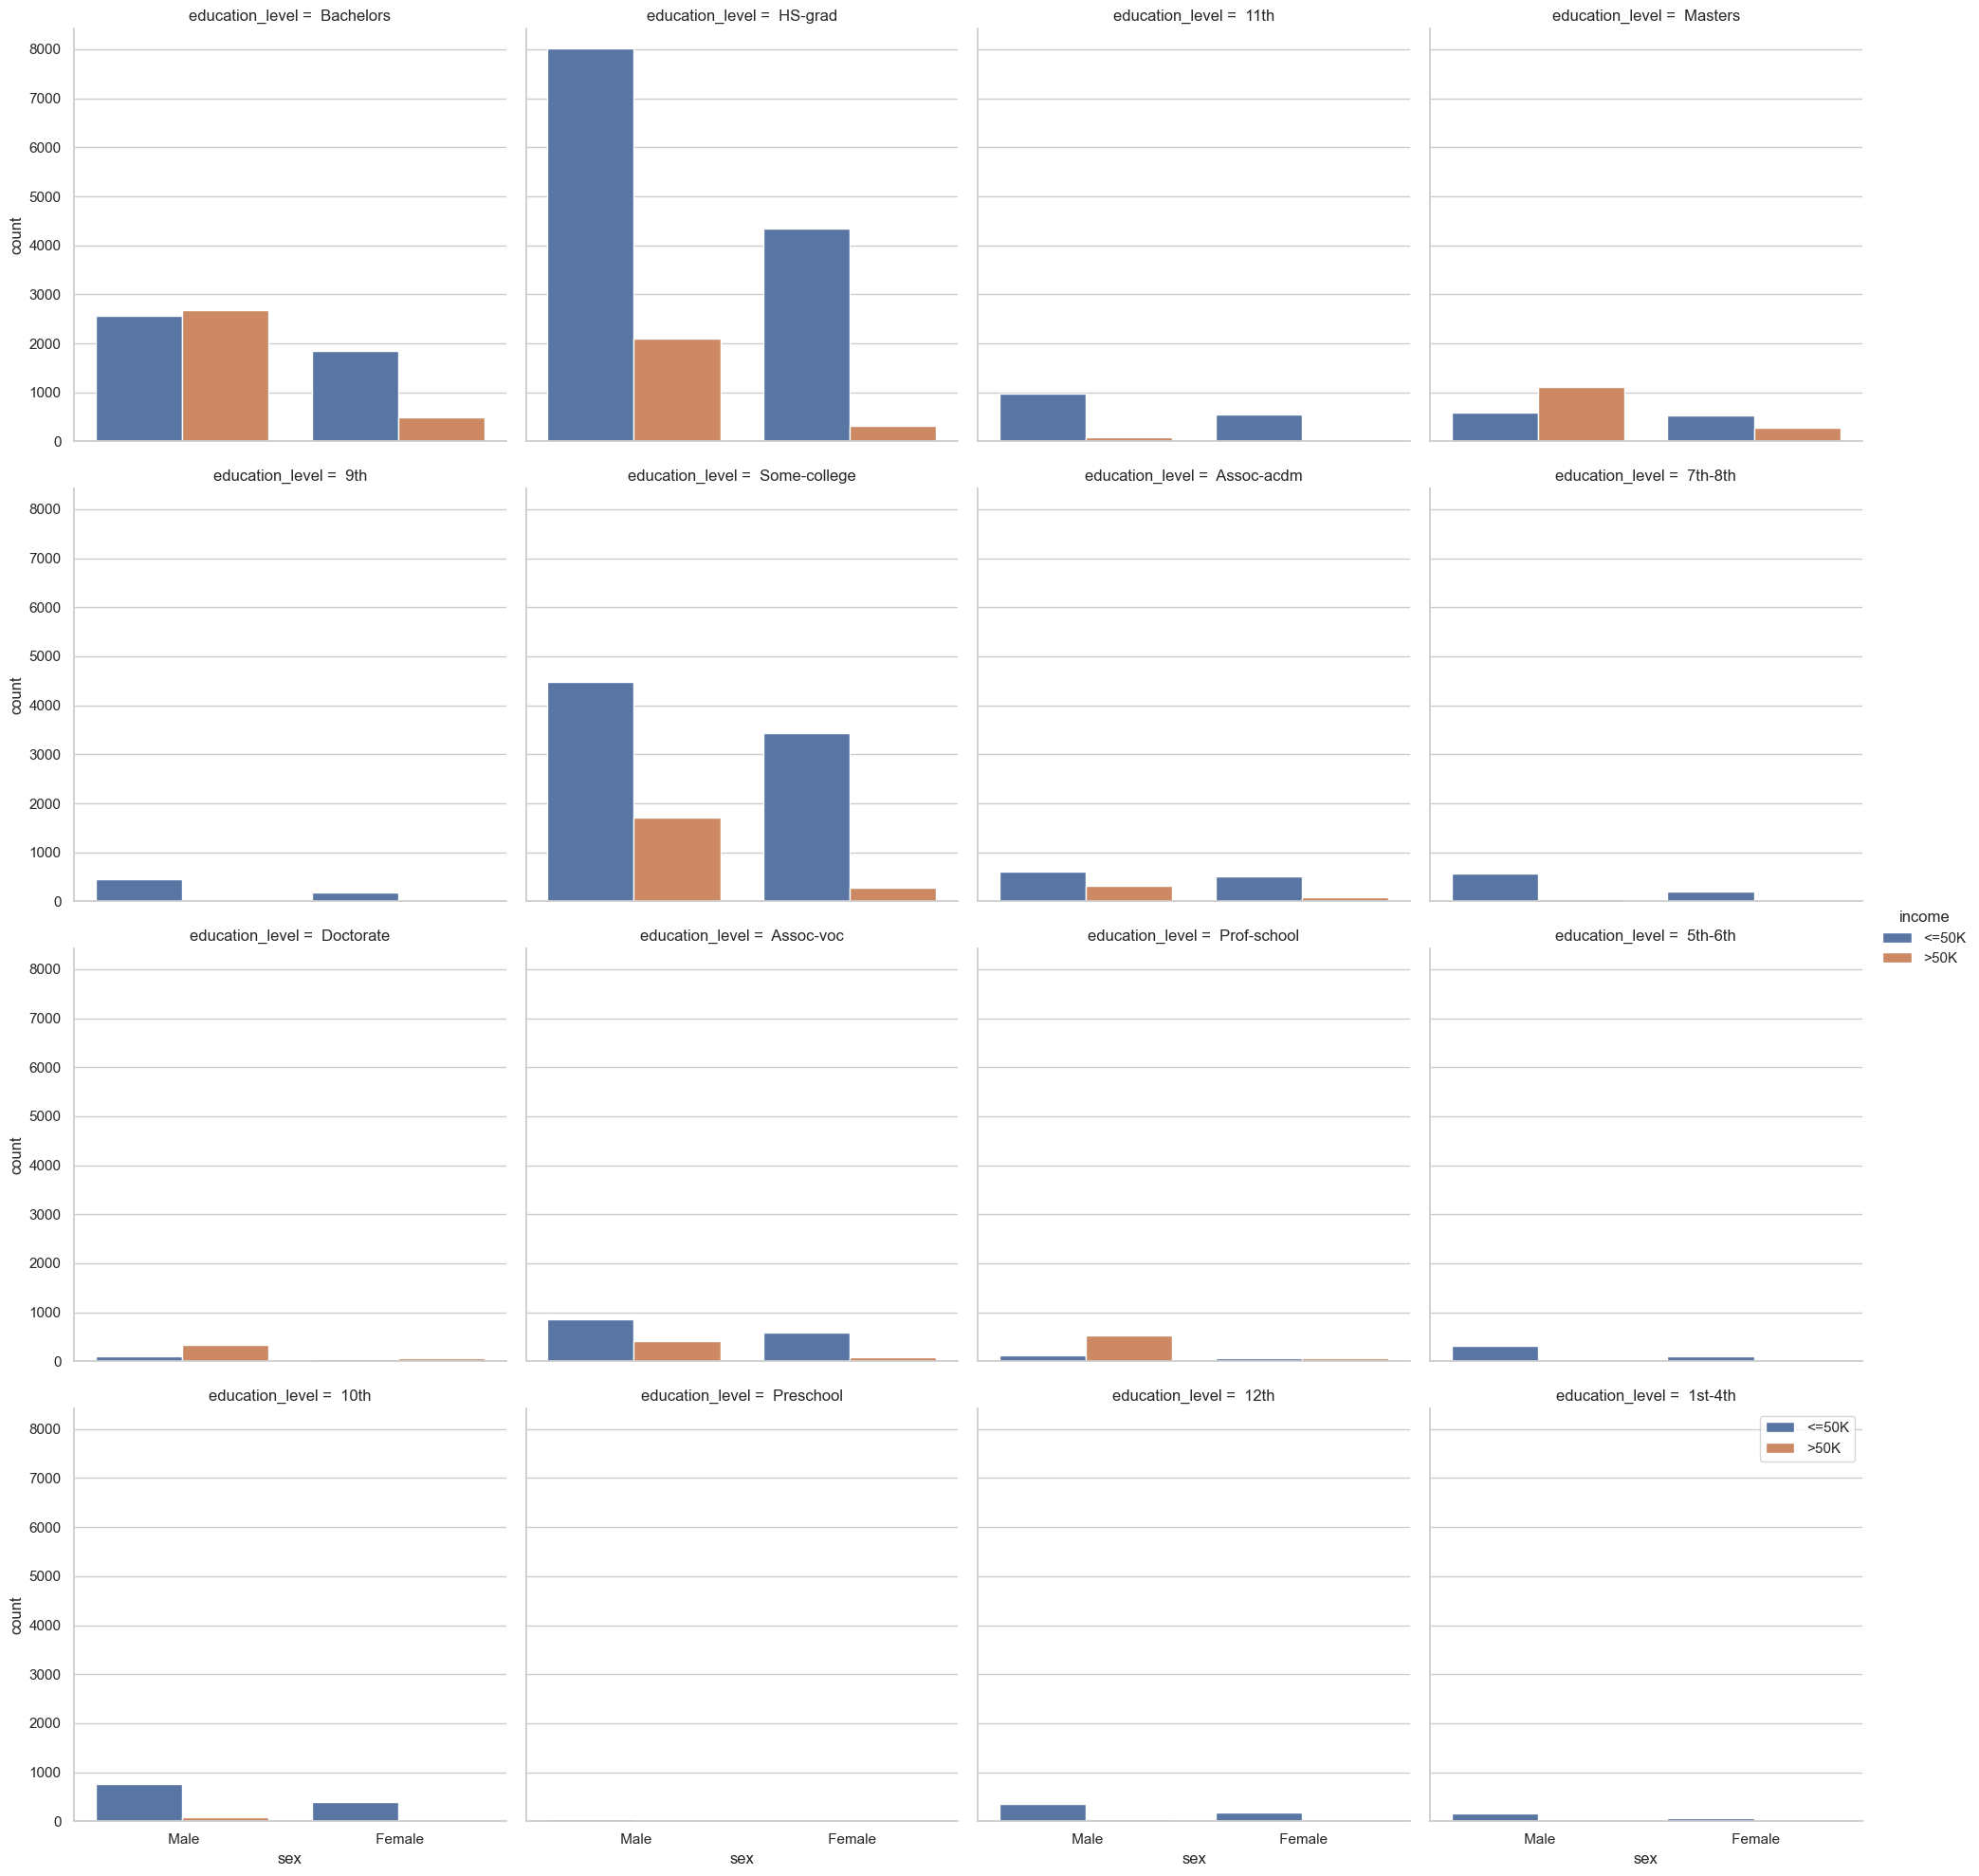

In [8]:
# One way to visualize the relationship is by using a seaborn catplot

sns.catplot(x="sex", col='education_level', data=data, hue='income', kind="count", col_wrap=4);
plt.legend()

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In [9]:
# Before we go on let's split the data into features and target label
features = data.drop('income', axis = 1)
target = data['income']

In [10]:
features


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can under-perform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Let's plot a histogram of these two features and see how they are distributed. (Have a look at the python script in this repo if you are interested in the code for this plotting function.)

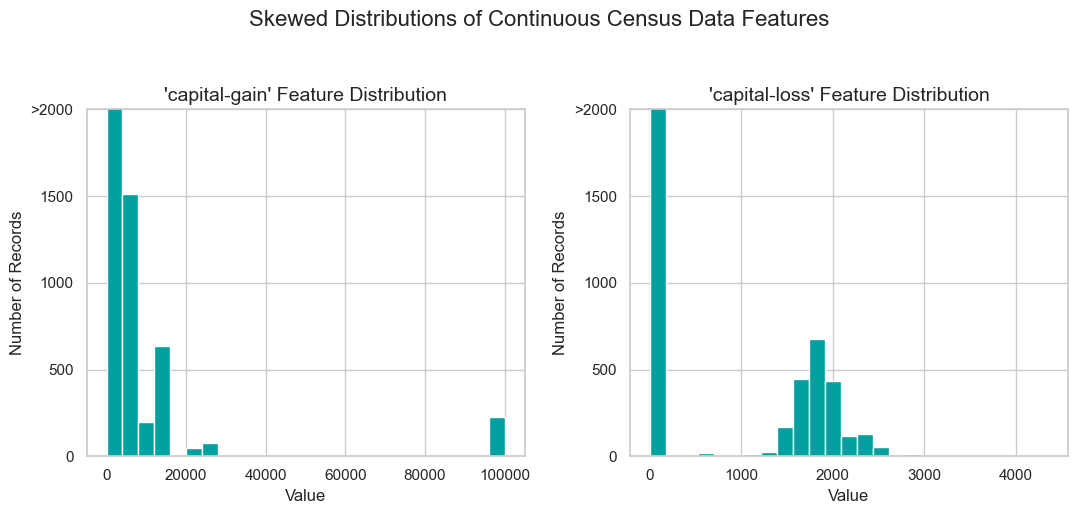

In [11]:
# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. 

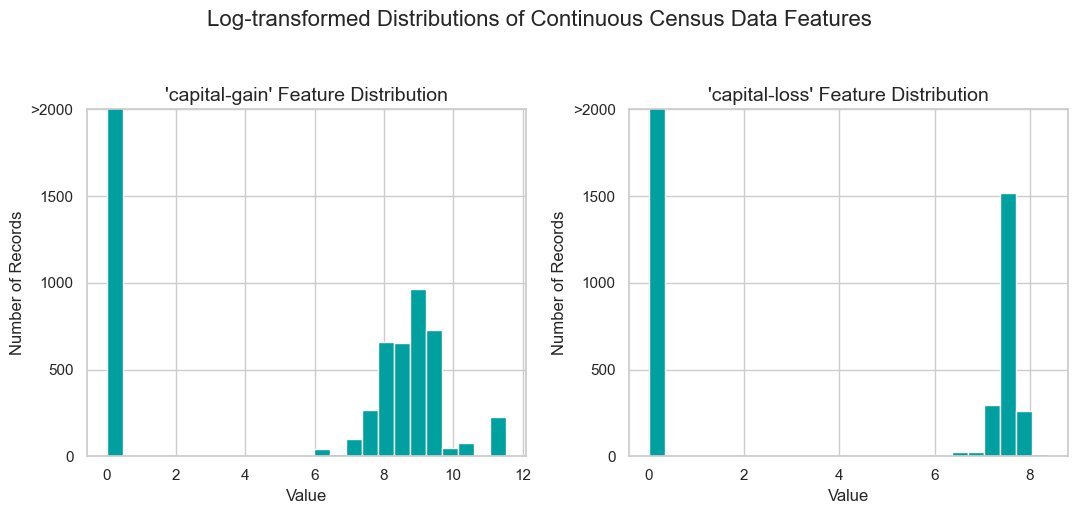

In [12]:
# Log-transform the skewed features ['capital-gain', 'capital-loss']
skewed = ['capital-gain', 'capital-loss']
features[skewed] = features[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions 
vs.distribution(features, transformed = True)

### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [13]:
features.head(2)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13.0,United-States


In [14]:
# TODO: One-hot encode the 'features' data using pandas.get_dummies()
features = pd.get_dummies(features)

# TODO: Encode the 'income'/'target' data to numerical values
target = target.apply(lambda x : 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
features.shape

(45222, 103)

### Shuffle and Split Data

Now all _categorical variables_ have been converted into numerical features. We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.  

In [15]:
# Plotting the target variable: unbalanced!
#plt.pie(target, autopct='%.0f%%')
#sns.pieplot(x=target)
#vector = np.array(target)
#plt.pie(vector, autopct='%.0f%%')

In [16]:
# Import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.2, random_state=RSEED)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Normalizing Numerical Features
It is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below. To avoid data leakage we will normalize the data after we split it into train and test set. 

In [17]:
# Import sklearn.preprocessing.StandardScaler, MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])
    
# Show an example of a record with scaling applied
X_train[numerical].sample(1)

,age,education-num,capital-gain,capital-loss,hours-per-week
25171,-0.952599,0.343819,-0.300689,-0.22438,0.75268


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. 

### Metrics and the Naive Predictor

*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performance would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision.

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say "*this person does not make more than \$50,000*" and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Naive Predictor Performance

What if we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset? (Remember what you calculated at the beginning of the notebook.)

In [18]:
# TODO: Calculate accuracy
accuracy = n_greater_50k / n_records

# TODO: Calculating precision
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

# TODO: Calculating recall
recall = n_greater_50k / (n_greater_50k + 0)

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


##  Supervised Learning Models

###  Model Application

Now we'll pick three supervised learning models above that are appropriate for this problem, and test them on the census data. 

**Decision Trees**

 - Real world application: Decision Trees and, in general, CART (Classification and Regression Trees) are often used in financial analysis. A concrete example of it is: for predicting which stocks to buy based on past performance. [Reference](https://ir.nctu.edu.tw/bitstream/11536/11962/1/000237645100007.pdf)
 - Strengths: 
      - Able to handle categorical and numerical data.
      - Doesn't require much data pre-processing, and can handle data which hasn't been normalized, or encoded for Machine Learning Suitability.
      - Simple to understand and interpret.
 - Weaknesses:
     - Complex Decision Trees do not generalize well to the data and can result in overfitting.
     - Unstable, as small variations in the data can result in a different decision tree. Hence they are usually used in an ensemble (like Random Forests) to build robustness.
     - Can create biased trees if some classes dominate.
 - Candidacy: Since a decision tree can handle both numerical and categorical data, it's a good candidate for our case (although, the pre-processing steps might already mitigate whatever advantage we would have had). It's also easy to interpret, so we will know what happens under the hood to interpret the results.


**Support Vector Machines (SVM)**

 - Real world application:  Example of a real world use of SVMs include image classification and image segmentation. For example: Face detection in an image. [Reference](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=9479f19abf29b205de03591938571193a0b93f0d)
 - Strengths: 
     - Effective in high dimensional spaces, or when there are a lot of features.
     - Kernel functions can be used to adapt to different cases, and can be completely customized if needed. Thus SVMs are versatile.
 - Weaknesses: 
     - Doesn't perform well with large datasets. 
     - Doesn't directly provide probability estimates.
 - Candidacy: SVMs were chosen because of their effectiveness given high dimensionality. After incorporating dummy variables, we have more than 100 features in our dataset, so SVMs should be a classifier that works regardless of that. Also, our dataset is not that large to be a deterrent. 
  

**Ensemble methods: AdaBoost**

 - Real world application: Ensemble methods are used extensively in Kaggle competitions, usually in image detection. A real world example of Adaboost is object detection in image, ex: identifying players during a game of basketball. [Reference](https://uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf)
 - Strength: 
     - Ensemble methods, including Adaboost are more robust than single estimators, have improved generalisability. 
     - Simple models can be combined to build a complex model, which is computationally fast. 
 - Weaknesses:
     - If we have a biased underlying classifier, it will lead to a biased boosted model.
 - Candidacy: Ensemble methods are considered to be high quality classifiers, and Adaboost is the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

In [19]:
# Import necessary metrics and models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

### Train and Compare the Models

In the next step we will train, evaluate and compare different models. You can decide if you want to write the code several times or if you want to do it in a nicer way by defining a function that does the work for you. 

In [20]:
# TODO: Train a decision tree, SVM and AdaBoostClassifier on the train data

dtree = DecisionTreeClassifier(random_state=101)
svm = SVC(probability=True, random_state=101)
ada = AdaBoostClassifier(random_state=101)

print('Fitting DTree...')
dtree.fit(X_train, y_train)
print('Fitting SVM...')
svm.fit(X_train, y_train)
print('Fitting AdaBoost...')
ada.fit(X_train, y_train)

Fitting DTree...
Fitting SVM...
Fitting AdaBoost...


AdaBoostClassifier(random_state=101)

### Model Evaluation

Now we can evaluate the performance of our models using the accuracy and the f-1 score as well as visualize the confusion matrix for the results.

Decision Tree:
Accuracy on training set: 0.97
Accuracy on test set: 0.81
----------------------------------------
Recall on training set: 0.91
Recall on test set: 0.6
----------------------------------------
Precision on training set: 0.98
Precision on test set: 0.63
----------------------------------------
fbeta_score on training set: 0.96
fbeta_score on test set: 0.63
----------------------------------------
roc_auc_score on trainig set:  1.0
roc_auc_score on test set:  0.77
----------------------------------------


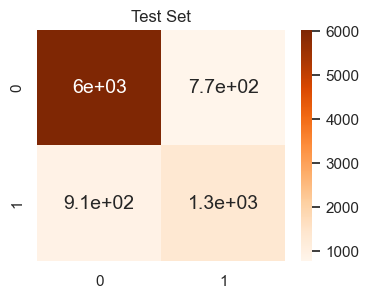

In [30]:
from os import path
import sys
sys.path.append(path.abspath('../')) #replace PATH with the path to Foo
from custom_python_functions.model_evaluation import (
    train_crossval_predict_score,
    predict_and_print_scores,
    plot_confusion_matrix,
    plot_distributions,
    plot_correlation,
    plot_roc_curves)

# TODO: Evaluate the different models comparing the accuracy and the f1-score

print('Decision Tree:')
predict_and_print_scores(dtree, X_train, y_train, X_test, y_test, fbeta=[True, 0.5], figsize=(4,3), cmap='Oranges')

SVM:
Accuracy on training set: 0.86
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.62
Recall on test set: 0.58
----------------------------------------
Precision on training set: 0.78
Precision on test set: 0.74
----------------------------------------
fbeta_score on training set: 0.74
fbeta_score on test set: 0.7
----------------------------------------


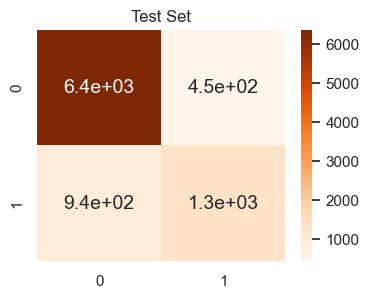

In [22]:
print('SVM:')
predict_and_print_scores(svm, X_train, y_train, X_test, y_test, roc_auc=False, fbeta=[True, 0.5], figsize=(4,3), cmap='Oranges')


AdaBoost:
Accuracy on training set: 0.86
Accuracy on test set: 0.85
----------------------------------------
Recall on training set: 0.61
Recall on test set: 0.59
----------------------------------------
Precision on training set: 0.77
Precision on test set: 0.76
----------------------------------------
fbeta_score on training set: 0.73
fbeta_score on test set: 0.72
----------------------------------------
roc_auc_score on trainig set:  0.92
roc_auc_score on test set:  0.91
----------------------------------------


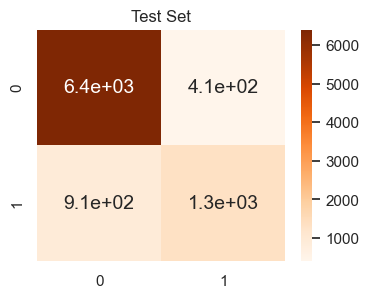

In [23]:
print('AdaBoost:')
predict_and_print_scores(ada, X_train, y_train, X_test, y_test, fbeta=[True, 0.5], figsize=(4,3),  cmap='Oranges')

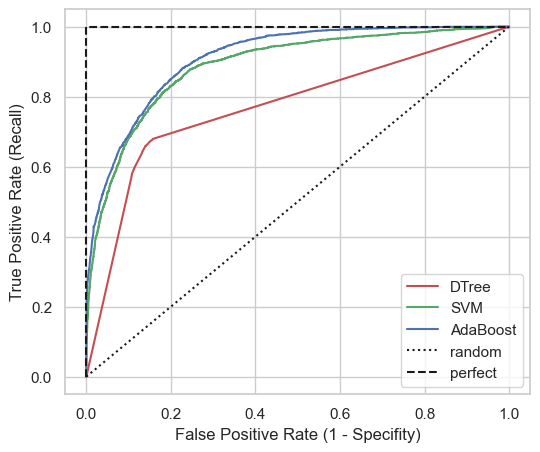

In [24]:
# TODO: Visualizing the confusion matrix for each classifier
# Evaluate your model 

model_dic={'DTree' : [dtree, 'r-'], 'SVM' : [svm, 'g-'], 'AdaBoost' : [ada, 'b-']}
plot_roc_curves(model_dic, X_test, y_test)

### Model Tuning
Using grid search (`GridSearchCV`) with different parameter/value combinations, we can tune our model for even better results. We will tune the AdaBoostClassifier since it showed the best performance. 
For Adaboost, we'll tune the n_estimators and learning rate parameters, and also the base classifier parameters (remember our base classifier for the Adaboost ensemble is a Decision tree!).

In [25]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 

# Initialize the classifier
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier()) 

# Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'estimator__min_samples_split' : np.arange(2, 8, 2),               
              'estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 


# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_model = GridSearchCV(clf, param_grid=parameters, cv=5, scoring=scorer, verbose=1, n_jobs=-1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'estimator__max_depth': array([1, 2, 3]),
                         'estimator__min_samples_split': array([2, 4, 6]),
                         'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 120]},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [26]:
# TODO: Get the  best estimator
best_clf = grid_model.best_estimator_

# TODO: Make predictions using the un-optimized model
predictions = ada.predict(X_test)

# TODO: Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the before-and-after scores
print("Un-optimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

Un-optimized model
------
Accuracy score on testing data: 0.8537
F-score on testing data: 0.7221

Optimized Model
------
Final accuracy score on the testing data: 0.8639
Final F-score on the testing data: 0.7461
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_split=6),
                   learning_rate=0.1, n_estimators=120)


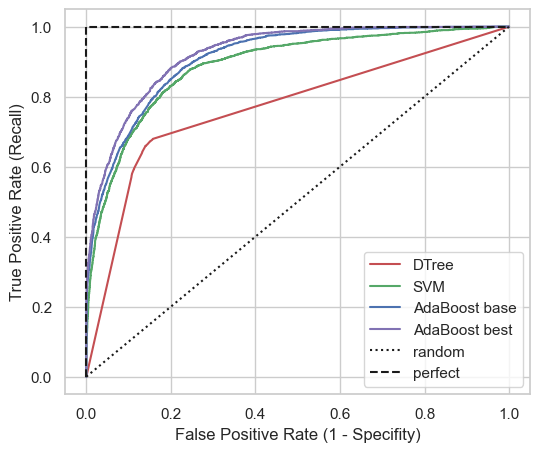

In [27]:
model_dic={'DTree' : [dtree, 'r-'], 'SVM' : [svm, 'g-'], 'AdaBoost base' : [ada, 'b-'], 'AdaBoost best' : [best_clf, 'm-']}
plot_roc_curves(model_dic, X_test, y_test)

## Solution

If you want to compare or get an interpretation of your results, have a look at the [solution notebook](4_SOLUTON_Comparison_Classification_Algorithms.ipynb). 

It will not only show you one possible approach to evaluate and compare those models but also compare the time the models need for training and predicting. 
At the very end of the notebook you will also get a first idea of how you could perform feature selection. 